### Import Library

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import plotly.express as px
plt.style.use('fivethirtyeight')

from sklearn.preprocessing import MinMaxScaler 

import tensorflow as tf

import numpy as np
import pandas as pd
import math

from sklearn.metrics import mean_squared_error as mse
from keras.losses import MeanAbsolutePercentageError

from keras.initializers import RandomUniform

# Hide GPU from visible devices
tf.config.set_visible_devices([], 'GPU')

### Import Dataset

In [2]:
df = pd.read_csv('data/data_ctm.csv')

### EDA

In [3]:
# Convert Dataset into DataFrame
# dataset = pd.DataFrame(dataset)
df.head()

,Month,Use_CTM
0,2015-01-01,6437
1,2015-02-01,7048
2,2015-03-01,8305
3,2015-04-01,7741
4,2015-05-01,7851


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Month    84 non-null     object
 1   Use_CTM  84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [5]:
df.isna().sum()

Month      0
Use_CTM    0
dtype: int64

In [6]:
df.describe()

,Use_CTM
count,84.000000
mean,7613.440476
std,553.152615
min,6389.000000
25%,7238.750000
50%,7698.000000
75%,8099.500000
max,8324.000000


In [7]:
df['Month'] = pd.to_datetime(df['Month']).dt.date
df.head()

,Month,Use_CTM
0,2015-01-01,6437
1,2015-02-01,7048
2,2015-03-01,8305
3,2015-04-01,7741
4,2015-05-01,7851


In [8]:
plot = px.line(df, x=df.Month, y=df.Use_CTM)
plot.show()

In [9]:
plot = px.histogram(df, x=df.Use_CTM, marginal='box')
plot.show()

### Data Preprocessing

In [10]:
df['Month'] = pd.to_datetime(df['Month']).dt.to_period('M')

In [11]:
df.set_index('Month', inplace=True)
df.head()

,Use_CTM
Month,
2015-01,6437
2015-02,7048
2015-03,8305
2015-04,7741
2015-05,7851


In [12]:
df = df.values

In [13]:
scaler = MinMaxScaler(feature_range=(0, 1))
df = scaler.fit_transform(df)
df

array([[0.0248062 ],
       [0.34056848],
       [0.99018088],
       [0.69870801],
       [0.75555556],
       [0.98087855],
       [0.40775194],
       [0.40155039],
       [0.95813953],
       [0.31472868],
       [0.91731266],
       [0.7870801 ],
       [0.13850129],
       [0.88165375],
       [0.78242894],
       [0.88372093],
       [0.94470284],
       [0.90077519],
       [0.66666667],
       [0.        ],
       [0.66976744],
       [0.81498708],
       [0.57105943],
       [0.32816537],
       [0.34005168],
       [0.68320413],
       [0.73333333],
       [0.99328165],
       [0.55090439],
       [0.73333333],
       [0.55710594],
       [0.97260982],
       [0.97260982],
       [0.85219638],
       [0.10904393],
       [0.0630491 ],
       [0.9870801 ],
       [0.6625323 ],
       [0.33436693],
       [0.94521964],
       [0.28630491],
       [0.03307494],
       [0.8878553 ],
       [0.6997416 ],
       [0.29870801],
       [0.66098191],
       [1.        ],
       [0.754

In [14]:
train_size = int(len(df) * 0.8)
test_size = (len(df)) - train_size
print(train_size, test_size)

67 17


In [15]:
train , test = df[0:train_size,:] , df[train_size:len(df),:]

In [16]:
def to_sequences(df, seq_size):
    x = []
    y = []

    for i in range(len(df)-seq_size):
        window = df[i:(i+seq_size), 0]
        x.append(window)
        y.append(df[i+seq_size, 0])

    return np.array(x), np.array(y)

In [17]:
seq_size = 5

trainX, trainY = to_sequences(train, seq_size)
testX, testY = to_sequences(test, seq_size)

print("Shape of training set: {}".format(trainX.shape))
print("Shape of testinf set: {}".format(testX.shape))

Shape of training set: (62, 5)
Shape of testinf set: (12, 5)


In [18]:
mape = MeanAbsolutePercentageError()

### Model 1

In [19]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model1.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model1.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=50, batch_size=6)

model1.evaluate(testX, testY)


1/1 [==============================] - 0s 185ms/step - loss: 0.0291 - mean_absolute_error: 0.1404


[0.029137611389160156, 0.14044985175132751]

In [20]:
trainPredict1 = model1.predict(trainX)
testPredict1 = model1.predict(testX)

trainPredict1 = scaler.inverse_transform(trainPredict1)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict1 = scaler.inverse_transform(testPredict1)
testY_inverse = scaler.inverse_transform([testY])

print('Model 1')

trainScore1 = math.sqrt(mse(trainY_inverse[0], trainPredict1[:,0]))
print('Train score: %.2f' % (trainScore1))

testScore1 = math.sqrt(mse(testY_inverse[0], testPredict1[:,0]))
print('Test score: %.2f' % (testScore1))

1/1 [==============================] - 0s 41ms/step
Model 1
Train score: 516.81
Test score: 330.30


In [21]:
mapeTrain1 = mape(trainY_inverse, trainPredict1)
print('MAPE Train   :  ', mapeTrain1.numpy())
print('Akurasi Train: ', 100 - (mapeTrain1.numpy()))

mape1 = mape(testY_inverse, testPredict1)
print('MAPE Test    :  ', mape1.numpy())
print('Akurasi Test : ', 100 - (mape1.numpy()))

MAPE Train   :   6.9466863
Akurasi Train:  93.05331373214722
MAPE Test    :   3.7653658
Akurasi Test :  96.23463416099548


### Model 2

In [22]:
model2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model2.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model2.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=100, batch_size=6)

model2.evaluate(testX, testY)


1/1 [==============================] - 0s 145ms/step - loss: 0.0280 - mean_absolute_error: 0.1426


[0.027984201908111572, 0.14259827136993408]

In [23]:
trainPredict2 = model2.predict(trainX)
testPredict2 = model2.predict(testX)

trainPredict2 = scaler.inverse_transform(trainPredict2)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict2 = scaler.inverse_transform(testPredict2)
testY_inverse = scaler.inverse_transform([testY])

print('Model 2')

trainScore2 = math.sqrt(mse(trainY_inverse[0], trainPredict2[:,0]))
print('Train score: %.2f' % (trainScore2))

testScore2 = math.sqrt(mse(testY_inverse[0], testPredict2[:,0]))
print('Test score: %.2f' % (testScore2))

1/1 [==============================] - 0s 82ms/step
Model 2
Train score: 478.57
Test score: 323.70


In [24]:
mapeTrain2 = mape(trainY_inverse, trainPredict2)
print('MAPE Train: ', mapeTrain2.numpy())
print('Akurasi Train: ', 100 - (mapeTrain2.numpy()))

mape2 = mape(testY_inverse, testPredict2)
print('MAPE Test: ', mape2.numpy())
print('Akurasi Test: ', 100 - (mape2.numpy()))

MAPE Train:  7.147248
Akurasi Train:  92.85275220870972
MAPE Test:  4.043438
Akurasi Test:  95.95656204223633


### Model 3

In [25]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model3.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model3.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=150, batch_size=6)

model3.evaluate(testX, testY)


1/1 [==============================] - 0s 129ms/step - loss: 0.0265 - mean_absolute_error: 0.1315


[0.026543786749243736, 0.13152576982975006]

In [26]:
trainPredict3 = model3.predict(trainX)
testPredict3 = model3.predict(testX)

trainPredict3 = scaler.inverse_transform(trainPredict3)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict3 = scaler.inverse_transform(testPredict3)
testY_inverse = scaler.inverse_transform([testY])

print('Model 3')

trainScore3 = math.sqrt(mse(trainY_inverse[0], trainPredict3[:,0]))
print('Train score: %.2f' % (trainScore3))

testScore3 = math.sqrt(mse(testY_inverse[0], testPredict3[:,0]))
print('Test score: %.2f' % (testScore3))

1/1 [==============================] - 0s 27ms/step
Model 3
Train score: 443.83
Test score: 315.26


In [27]:
mapeTrain3 = mape(trainY_inverse, trainPredict3)
print('MAPE Train: ', mapeTrain3.numpy())
print('Akurasi Train: ', 100 - (mapeTrain3.numpy()))

mape3 = mape(testY_inverse, testPredict3)
print('MAPE Test: ', mape3.numpy())
print('Akurasi Test: ', 100 - (mape3.numpy()))

MAPE Train:  7.3832664
Akurasi Train:  92.61673355102539
MAPE Test:  3.9005902
Akurasi Test:  96.09940981864929


### Model 4

In [28]:
model4 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model4.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model4.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=200, batch_size=6)

model4.evaluate(testX, testY)


1/1 [==============================] - 0s 132ms/step - loss: 0.0515 - mean_absolute_error: 0.1888


[0.05150212347507477, 0.18875963985919952]

In [29]:
trainPredict4 = model4.predict(trainX)
testPredict4 = model4.predict(testX)

trainPredict4 = scaler.inverse_transform(trainPredict4)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict4 = scaler.inverse_transform(testPredict4)
testY_inverse = scaler.inverse_transform([testY])

print('Model 4')

trainScore4 = math.sqrt(mse(trainY_inverse[0], trainPredict4[:,0]))
print('Train score: %.2f' % (trainScore4))

testScore4 = math.sqrt(mse(testY_inverse[0], testPredict4[:,0]))
print('Test score: %.2f' % (testScore4))

1/1 [==============================] - 0s 28ms/step
Model 4
Train score: 431.87
Test score: 439.13


In [30]:
mapeTrain4 = mape(trainY_inverse, trainPredict4)
print('MAPE Train: ', mapeTrain4.numpy())
print('Akurasi Train: ', 100 - (mapeTrain4.numpy()))

mape4 = mape(testY_inverse, testPredict4)
print('MAPE Test: ', mape4.numpy())
print('Akurasi Test: ', 100 - (mape4.numpy()))

MAPE Train:  7.440817
Akurasi Train:  92.55918312072754
MAPE Test:  4.0804095
Akurasi Test:  95.91959047317505


### Model 5

In [31]:
model5 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model5.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model5.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=250, batch_size=6)

model5.evaluate(testX, testY)


1/1 [==============================] - 0s 136ms/step - loss: 0.0530 - mean_absolute_error: 0.1941


[0.053007498383522034, 0.19410818815231323]

In [34]:
trainPredict5 = model5.predict(trainX)
testPredict5 = model5.predict(testX)

trainPredict5 = scaler.inverse_transform(trainPredict5)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict5 = scaler.inverse_transform(testPredict5)
testY_inverse = scaler.inverse_transform([testY])

print('Model 5')

trainScore5 = math.sqrt(mse(trainY_inverse[0], trainPredict5[:,0]))
print('Train score: %.2f' % (trainScore5))

testScore5 = math.sqrt(mse(testY_inverse[0], testPredict5[:,0]))
print('Test score: %.2f' % (testScore5))

1/1 [==============================] - 0s 29ms/step
Model 5
Train score: 409.17
Test score: 445.50


In [35]:
mapeTrain5 = mape(trainY_inverse, trainPredict5)
print('MAPE Train: ', mapeTrain5.numpy())
print('Akurasi Train: ', 100 - (mapeTrain5.numpy()))

mape5 = mape(testY_inverse, testPredict5)
print('MAPE Test: ', mape5.numpy())
print('Akurasi Test: ', 100 - (mape5.numpy()))

MAPE Train:  7.4922075
Akurasi Train:  92.50779247283936
MAPE Test:  4.348095
Akurasi Test:  95.65190505981445


### Model 6

In [36]:
model6 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model6.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model6.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=300, batch_size=6)

model6.evaluate(testX, testY)


1/1 [==============================] - 0s 131ms/step - loss: 0.0631 - mean_absolute_error: 0.2147


[0.06312939524650574, 0.21471090614795685]

In [37]:
trainPredict6 = model6.predict(trainX)
testPredict6 = model6.predict(testX)

trainPredict6 = scaler.inverse_transform(trainPredict6)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict6 = scaler.inverse_transform(testPredict6)
testY_inverse = scaler.inverse_transform([testY])

print('Model 6')

trainScore6 = math.sqrt(mse(trainY_inverse[0], trainPredict6[:,0]))
print('Train score: %.2f' % (trainScore6))

testScore6 = math.sqrt(mse(testY_inverse[0], testPredict6[:,0]))
print('Test score: %.2f' % (testScore6))

1/1 [==============================] - 0s 33ms/step
Model 6
Train score: 332.81
Test score: 486.18


In [38]:
mapeTrain6 = mape(trainY_inverse, trainPredict6)
print('MAPE Train: ', mapeTrain6.numpy())
print('Akurasi Train: ', 100 - (mapeTrain6.numpy()))

mape6 = mape(testY_inverse, testPredict6)
print('MAPE Test: ', mape6.numpy())
print('Akurasi Test: ', 100 - (mape6.numpy()))

MAPE Train:  8.093624
Akurasi Train:  91.90637588500977
MAPE Test:  5.4194245
Akurasi Test:  94.580575466156


### Model 7

In [39]:
model7 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model7.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model7.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=50, batch_size=8)

model7.evaluate(testX, testY)


1/1 [==============================] - 0s 31ms/step - loss: 0.0299 - mean_absolute_error: 0.1445


[0.029933372512459755, 0.1444588303565979]

In [40]:
trainPredict7 = model7.predict(trainX)
testPredict7 = model7.predict(testX)

trainPredict7 = scaler.inverse_transform(trainPredict7)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict7 = scaler.inverse_transform(testPredict7)
testY_inverse = scaler.inverse_transform([testY])

print('Model 7')

trainScore7 = math.sqrt(mse(trainY_inverse[0], trainPredict7[:,0]))
print('Train score: %.2f' % (trainScore7))

testScore7 = math.sqrt(mse(testY_inverse[0], testPredict7[:,0]))
print('Test score: %.2f' % (testScore7))

1/1 [==============================] - 0s 29ms/step
Model 7
Train score: 530.57
Test score: 334.78


In [41]:
mapeTrain7 = mape(trainY_inverse, trainPredict7)
print('MAPE Train: ', mapeTrain7.numpy())
print('Akurasi Train: ', 100 - (mapeTrain7.numpy()))

mape7 = mape(testY_inverse, testPredict7)
print('MAPE Test: ', mape7.numpy())
print('Akurasi Test: ', 100 - (mape7.numpy()))

MAPE Train:  6.9418697
Akurasi Train:  93.05813026428223
MAPE Test:  3.7679765
Akurasi Test:  96.23202347755432


### Model 8

In [42]:
model8 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model8.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model8.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=100, batch_size=8)

model8.evaluate(testX, testY)


1/1 [==============================] - 0s 36ms/step - loss: 0.0480 - mean_absolute_error: 0.1822


[0.047983866184949875, 0.1822274923324585]

In [43]:
trainPredict8 = model8.predict(trainX)
testPredict8 = model8.predict(testX)

trainPredict8 = scaler.inverse_transform(trainPredict8)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict8 = scaler.inverse_transform(testPredict8)
testY_inverse = scaler.inverse_transform([testY])

print('Model 8')

trainScore8 = math.sqrt(mse(trainY_inverse[0], trainPredict8[:,0]))
print('Train score: %.2f' % (trainScore8))

testScore8 = math.sqrt(mse(testY_inverse[0], testPredict8[:,0]))
print('Test score: %.2f' % (testScore8))

1/1 [==============================] - 0s 31ms/step
Model 8
Train score: 484.57
Test score: 423.87


In [44]:
mapeTrain8 = mape(trainY_inverse, trainPredict8)
print('MAPE Train: ', mapeTrain8.numpy())
print('Akurasi Train: ', 100 - (mapeTrain8.numpy()))

mape8 = mape(testY_inverse, testPredict8)
print('MAPE Test: ', mape8.numpy())
print('Akurasi Test: ', 100 - (mape8.numpy()))

MAPE Train:  7.1853805
Akurasi Train:  92.81461954116821
MAPE Test:  4.188151
Akurasi Test:  95.81184911727905


### Model 9

In [45]:
model9 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model9.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model9.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=150, batch_size=8)

model9.evaluate(testX, testY)


1/1 [==============================] - 0s 34ms/step - loss: 0.0359 - mean_absolute_error: 0.1517


[0.035855989903211594, 0.15166743099689484]

In [47]:
trainPredict9 = model9.predict(trainX)
testPredict9 = model9.predict(testX)

trainPredict9 = scaler.inverse_transform(trainPredict9)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict9 = scaler.inverse_transform(testPredict9)
testY_inverse = scaler.inverse_transform([testY])

print('Model 9')

trainScore9 = math.sqrt(mse(trainY_inverse[0], trainPredict9[:,0]))
print('Train score: %.2f' % (trainScore9))

testScore9 = math.sqrt(mse(testY_inverse[0], testPredict9[:,0]))
print('Test score: %.2f' % (testScore9))

1/1 [==============================] - 0s 32ms/step
Model 9
Train score: 433.99
Test score: 366.41


In [48]:
mapeTrain9 = mape(trainY_inverse, trainPredict9)
print('MAPE Train: ', mapeTrain9.numpy())
print('Akurasi Train: ', 100 - (mapeTrain9.numpy()))

mape9 = mape(testY_inverse, testPredict9)
print('MAPE Test: ', mape9.numpy())
print('Akurasi Test: ', 100 - (mape9.numpy()))

MAPE Train:  7.331121
Akurasi Train:  92.66887903213501
MAPE Test:  3.4728477
Akurasi Test:  96.52715229988098


### Model 10

In [49]:
model10 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model10.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model10.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=200, batch_size=8)

model10.evaluate(testX, testY)


1/1 [==============================] - 0s 35ms/step - loss: 0.0573 - mean_absolute_error: 0.2030


[0.057349640876054764, 0.20304031670093536]

In [50]:
trainPredict10 = model10.predict(trainX)
testPredict10 = model10.predict(testX)

trainPredict10 = scaler.inverse_transform(trainPredict10)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict10 = scaler.inverse_transform(testPredict10)
testY_inverse = scaler.inverse_transform([testY])

print('Model 10')

trainScore10 = math.sqrt(mse(trainY_inverse[0], trainPredict10[:,0]))
print('Train score: %.2f' % (trainScore10))

testScore10 = math.sqrt(mse(testY_inverse[0], testPredict10[:,0]))
print('Test score: %.2f' % (testScore10))

1/1 [==============================] - 0s 29ms/step
Model 10
Train score: 433.39
Test score: 463.39


In [51]:
mapeTrain10 = mape(trainY_inverse, trainPredict10)
print('MAPE Train: ', mapeTrain10.numpy())
print('Akurasi Train: ', 100 - (mapeTrain10.numpy()))

mape10 = mape(testY_inverse, testPredict10)
print('MAPE Test: ', mape10.numpy())
print('Akurasi Test: ', 100 - (mape10.numpy()))

MAPE Train:  7.3951335
Akurasi Train:  92.60486650466919
MAPE Test:  4.3877025
Akurasi Test:  95.61229753494263


### Model 11

In [52]:
model11 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model11.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model11.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=250, batch_size=8)

model11.evaluate(testX, testY)


1/1 [==============================] - 0s 27ms/step - loss: 0.0695 - mean_absolute_error: 0.2149


[0.06947530061006546, 0.2149323672056198]

In [53]:
trainPredict11 = model11.predict(trainX)
testPredict11 = model11.predict(testX)

trainPredict11 = scaler.inverse_transform(trainPredict11)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict11 = scaler.inverse_transform(testPredict11)
testY_inverse = scaler.inverse_transform([testY])

print('Model 11')

trainScore11 = math.sqrt(mse(trainY_inverse[0], trainPredict11[:,0]))
print('Train score: %.2f' % (trainScore11))

testScore11 = math.sqrt(mse(testY_inverse[0], testPredict11[:,0]))
print('Test score: %.2f' % (testScore11))

1/1 [==============================] - 0s 25ms/step
Model 11
Train score: 428.50
Test score: 510.03


In [54]:
mapeTrain11 = mape(trainY_inverse, trainPredict11)
print('MAPE Train: ', mapeTrain11.numpy())
print('Akurasi Train: ', 100 - (mapeTrain11.numpy()))

mape11 = mape(testY_inverse, testPredict11)
print('MAPE Test: ', mape11.numpy())
print('Akurasi Test: ', 100 - (mape11.numpy()))

MAPE Train:  7.388467
Akurasi Train:  92.61153316497803
MAPE Test:  4.5822425
Akurasi Test:  95.41775751113892


### Model 12

In [55]:
model12 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model12.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model12.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=300, batch_size=8)

model12.evaluate(testX, testY)


1/1 [==============================] - 0s 30ms/step - loss: 0.0244 - mean_absolute_error: 0.1332


[0.024381661787629128, 0.1331651359796524]

In [56]:
trainPredict12 = model12.predict(trainX)
testPredict12 = model12.predict(testX)

trainPredict12 = scaler.inverse_transform(trainPredict12)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict12 = scaler.inverse_transform(testPredict12)
testY_inverse = scaler.inverse_transform([testY])

print('Model 12')

trainScore12 = math.sqrt(mse(trainY_inverse[0], trainPredict12[:,0]))
print('Train score: %.2f' % (trainScore12))

testScore12 = math.sqrt(mse(testY_inverse[0], testPredict12[:,0]))
print('Test score: %.2f' % (testScore12))

1/1 [==============================] - 0s 25ms/step
Model 12
Train score: 332.37
Test score: 302.14


In [57]:
mapeTrain12 = mape(trainY_inverse, trainPredict12)
print('MAPE Train: ', mapeTrain12.numpy())
print('Akurasi Train: ', 100 - (mapeTrain12.numpy()))

mape12 = mape(testY_inverse, testPredict12)
print('MAPE : ', mape12.numpy())
print('Akurasi : ', 100 - (mape12.numpy()))

MAPE Train:  7.8173537
Akurasi Train:  92.18264627456665
MAPE :  3.742321
Akurasi :  96.2576789855957


### Model 13

In [58]:
model13 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model13.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model13.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=50, batch_size=12)

model13.evaluate(testX, testY)


1/1 [==============================] - 0s 138ms/step - loss: 0.0324 - mean_absolute_error: 0.1540


[0.03237471729516983, 0.15398114919662476]

In [59]:
trainPredict13 = model13.predict(trainX)
testPredict13 = model13.predict(testX)

trainPredict13 = scaler.inverse_transform(trainPredict13)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict13 = scaler.inverse_transform(testPredict13)
testY_inverse = scaler.inverse_transform([testY])

print('Model 13')

trainScore13 = math.sqrt(mse(trainY_inverse[0], trainPredict13[:,0]))
print('Train score: %.2f' % (trainScore13))

testScore13 = math.sqrt(mse(testY_inverse[0], testPredict13[:,0]))
print('Test score: %.2f' % (testScore13))

1/1 [==============================] - 0s 31ms/step
Model 13
Train score: 538.78
Test score: 348.16


In [60]:
mapeTrain13 = mape(trainY_inverse, trainPredict13)
print('MAPE Train: ', mapeTrain13.numpy())
print('Akurasi Train: ', 100 - (mapeTrain13.numpy()))

mape13 = mape(testY_inverse, testPredict13)
print('MAPE Test: ', mape13.numpy())
print('Akurasi Test: ', 100 - (mape13.numpy()))

MAPE Train:  6.9933662
Akurasi Train:  93.00663375854492
MAPE Test:  3.9257104
Akurasi Test:  96.074289560318


### Model 14

In [61]:
model14 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model14.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model14.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=100, batch_size=12)

model14.evaluate(testX, testY)


1/1 [==============================] - 0s 128ms/step - loss: 0.0275 - mean_absolute_error: 0.1424


[0.027489012107253075, 0.14242441952228546]

In [62]:
trainPredict14 = model14.predict(trainX)
testPredict14 = model14.predict(testX)

trainPredict14 = scaler.inverse_transform(trainPredict14)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict14 = scaler.inverse_transform(testPredict14)
testY_inverse = scaler.inverse_transform([testY])

print('Model 14')

trainScore14 = math.sqrt(mse(trainY_inverse[0], trainPredict14[:,0]))
print('Train score: %.2f' % (trainScore14))

testScore14 = math.sqrt(mse(testY_inverse[0], testPredict14[:,0]))
print('Test score: %.2f' % (testScore14))

1/1 [==============================] - 0s 30ms/step
Model 14
Train score: 524.65
Test score: 320.82


In [63]:
mapeTrain14 = mape(trainY_inverse, trainPredict14)
print('MAPE Train: ', mapeTrain14.numpy())
print('Akurasi Train: ', 100 - (mapeTrain14.numpy()))

mape14 = mape(testY_inverse, testPredict14)
print('MAPE Test: ', mape14.numpy())
print('Akurasi Test: ', 100 - (mape14.numpy()))

MAPE Train:  7.03948
Akurasi Train:  92.96051979064941
MAPE Test:  3.9550877
Akurasi Test:  96.04491233825684


### Model 15

In [64]:
model15 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model15.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model15.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=150, batch_size=12)

model15.evaluate(testX, testY)


1/1 [==============================] - 0s 147ms/step - loss: 0.0260 - mean_absolute_error: 0.1376


[0.025973888114094734, 0.13756883144378662]

In [65]:
trainPredict15 = model15.predict(trainX)
testPredict15 = model15.predict(testX)

trainPredict15 = scaler.inverse_transform(trainPredict15)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict15 = scaler.inverse_transform(testPredict15)
testY_inverse = scaler.inverse_transform([testY])

print('Model 15')

trainScore15 = math.sqrt(mse(trainY_inverse[0], trainPredict15[:,0]))
print('Train score: %.2f' % (trainScore15))

testScore15 = math.sqrt(mse(testY_inverse[0], testPredict15[:,0]))
print('Test score: %.2f' % (testScore15))

1/1 [==============================] - 0s 30ms/step
Model 15
Train score: 506.84
Test score: 311.85


In [66]:
mapeTrain15 = mape(trainY_inverse, trainPredict15)
print('MAPE Train: ', mapeTrain15.numpy())
print('Akurasi Train: ', 100 - (mapeTrain15.numpy()))

mape15 = mape(testY_inverse, testPredict15)
print('MAPE Test: ', mape15.numpy())
print('Akurasi Test: ', 100 - (mape15.numpy()))

MAPE Train:  7.1782246
Akurasi Train:  92.82177543640137
MAPE Test:  4.0674357
Akurasi Test:  95.93256425857544


### Model 16

In [67]:
model16 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model16.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model16.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=200, batch_size=12)

model16.evaluate(testX, testY)


1/1 [==============================] - 0s 136ms/step - loss: 0.0356 - mean_absolute_error: 0.1665


[0.03561722859740257, 0.16651032865047455]

In [68]:
trainPredict16 = model16.predict(trainX)
testPredict16 = model16.predict(testX)

trainPredict16 = scaler.inverse_transform(trainPredict16)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict16 = scaler.inverse_transform(testPredict16)
testY_inverse = scaler.inverse_transform([testY])

print('Model 16')

trainScore16 = math.sqrt(mse(trainY_inverse[0], trainPredict16[:,0]))
print('Train score: %.2f' % (trainScore16))

testScore16 = math.sqrt(mse(testY_inverse[0], testPredict16[:,0]))
print('Test score: %.2f' % (testScore16))

1/1 [==============================] - 0s 31ms/step
Model 16
Train score: 499.76
Test score: 365.18


In [69]:
mapeTrain16 = mape(trainY_inverse, trainPredict16)
print('MAPE Train: ', mapeTrain16.numpy())
print('Akurasi Train: ', 100 - (mapeTrain16.numpy()))

mape16 = mape(testY_inverse, testPredict16)
print('MAPE Test: ', mape16.numpy())
print('Akurasi Test: ', 100 - (mape16.numpy()))

MAPE Train:  7.159811
Akurasi Train:  92.84018898010254
MAPE Test:  4.132856
Akurasi Test:  95.8671441078186


### Model 17

In [70]:
model17 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model17.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model17.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=150, batch_size=12)

model17.evaluate(testX, testY)


1/1 [==============================] - 0s 125ms/step - loss: 0.0351 - mean_absolute_error: 0.1552


[0.0351211279630661, 0.15520557761192322]

In [71]:
trainPredict17 = model17.predict(trainX)
testPredict17 = model17.predict(testX)

trainPredict17 = scaler.inverse_transform(trainPredict17)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict17 = scaler.inverse_transform(testPredict17)
testY_inverse = scaler.inverse_transform([testY])

print('Model 17')

trainScore17 = math.sqrt(mse(trainY_inverse[0], trainPredict17[:,0]))
print('Train score: %.2f' % (trainScore17))

testScore17 = math.sqrt(mse(testY_inverse[0], testPredict17[:,0]))
print('Test score: %.2f' % (testScore17))

1/1 [==============================] - 0s 25ms/step
Model 17
Train score: 475.67
Test score: 362.63


In [72]:
mapeTrain17 = mape(trainY_inverse, trainPredict17)
print('MAPE Train: ', mapeTrain17.numpy())
print('Akurasi Train: ', 100 - (mapeTrain17.numpy()))

mape17 = mape(testY_inverse, testPredict17)
print('MAPE Test: ', mape17.numpy())
print('Akurasi Test: ', 100 - (mape17.numpy()))

MAPE Train:  7.2254047
Akurasi Train:  92.77459526062012
MAPE Test:  4.00376
Akurasi Test:  95.99624013900757


### Model 18

In [73]:
model18 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(12, input_dim=seq_size,
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(6, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1)),
    tf.keras.layers.Dense(1, activation='sigmoid',
                          kernel_initializer=RandomUniform(minval=-1, maxval=1), bias_initializer=RandomUniform(minval=-1, maxval=1))
])

model18.compile(loss='mse',
               optimizer=tf.keras.optimizers.Adam(0.01),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model18.fit(trainX, trainY, validation_data=(
    testX, testY), verbose=0, epochs=300, batch_size=12)

model18.evaluate(testX, testY)


1/1 [==============================] - 0s 133ms/step - loss: 0.0608 - mean_absolute_error: 0.2219


[0.06084504351019859, 0.2218582183122635]

In [74]:
trainPredict18 = model18.predict(trainX)
testPredict18 = model18.predict(testX)

trainPredict18 = scaler.inverse_transform(trainPredict18)
trainY_inverse = scaler.inverse_transform([trainY])
testPredict18 = scaler.inverse_transform(testPredict18)
testY_inverse = scaler.inverse_transform([testY])

print('Model 18')

trainScore18 = math.sqrt(mse(trainY_inverse[0], trainPredict18[:,0]))
print('Train score: %.2f' % (trainScore18))

testScore18 = math.sqrt(mse(testY_inverse[0], testPredict18[:,0]))
print('Test score: %.2f' % (testScore18))

1/1 [==============================] - 0s 27ms/step
Model 18
Train score: 382.43
Test score: 477.30


In [75]:
mapeTrain18 = mape(trainY_inverse, trainPredict18)
print('MAPE Train: ', mapeTrain18.numpy())
print('Akurasi Train: ', 100 - (mapeTrain18.numpy()))

mape18 = mape(testY_inverse, testPredict18)
print('MAPE Test: ', mape18.numpy())
print('Akurasi Test: ', 100 - (mape18.numpy()))

MAPE Train:  7.4841247
Akurasi Train:  92.51587533950806
MAPE Test:  5.1481853
Akurasi Test:  94.85181474685669


### Model 7 - Use

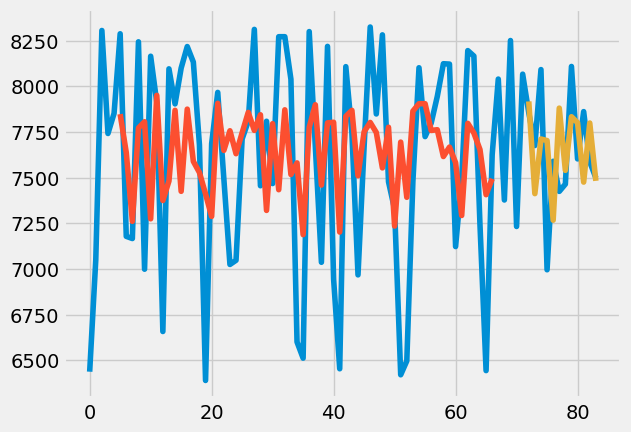

In [76]:
trainPredictPlot = np.empty_like(df)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[seq_size:len(trainPredict7)+seq_size, :] = trainPredict7

testPredictPlot = np.empty_like(df)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict7)+(seq_size*2):len(df), :] = testPredict7

plt.plot(scaler.inverse_transform(df))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [77]:
# Save Model
save_model = model7.save('model/model_ctm.h5',save_format='h5')
save_model

In [78]:
testY_inverse.transpose()

array([[7855.],
       [7675.],
       [8091.],
       [6995.],
       [7589.],
       [7424.],
       [7464.],
       [8108.],
       [7602.],
       [7861.],
       [7586.],
       [7498.]])

In [79]:
testPredict7

array([[7916.7534],
       [7411.836 ],
       [7710.823 ],
       [7702.282 ],
       [7266.429 ],
       [7879.893 ],
       [7539.2197],
       [7832.852 ],
       [7800.171 ],
       [7474.8076],
       [7798.46  ],
       [7481.697 ]], dtype=float32)